In [1]:
!pip install librosa


You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [1]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [2]:
train_audio_path = 'train/AudioClasses'

22050
110592


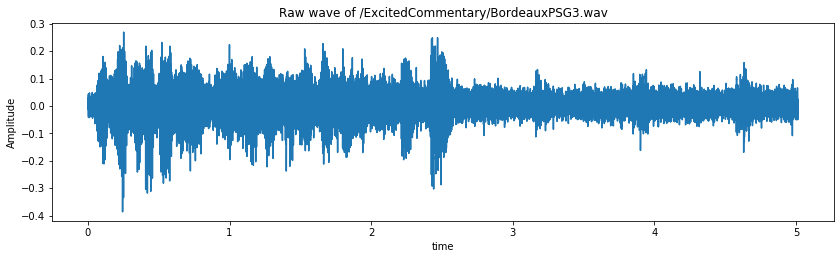

In [3]:
filename = '/ExcitedCommentary/BordeauxPSG3.wav'
samples, sample_rate = librosa.load(str(train_audio_path) + filename)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, len(samples)/sample_rate, len(samples)), samples)
print(sample_rate)
print(len(samples))

In [4]:
samples=np.array(samples, dtype='float64')
samples = librosa.resample(samples, sample_rate, 8000)

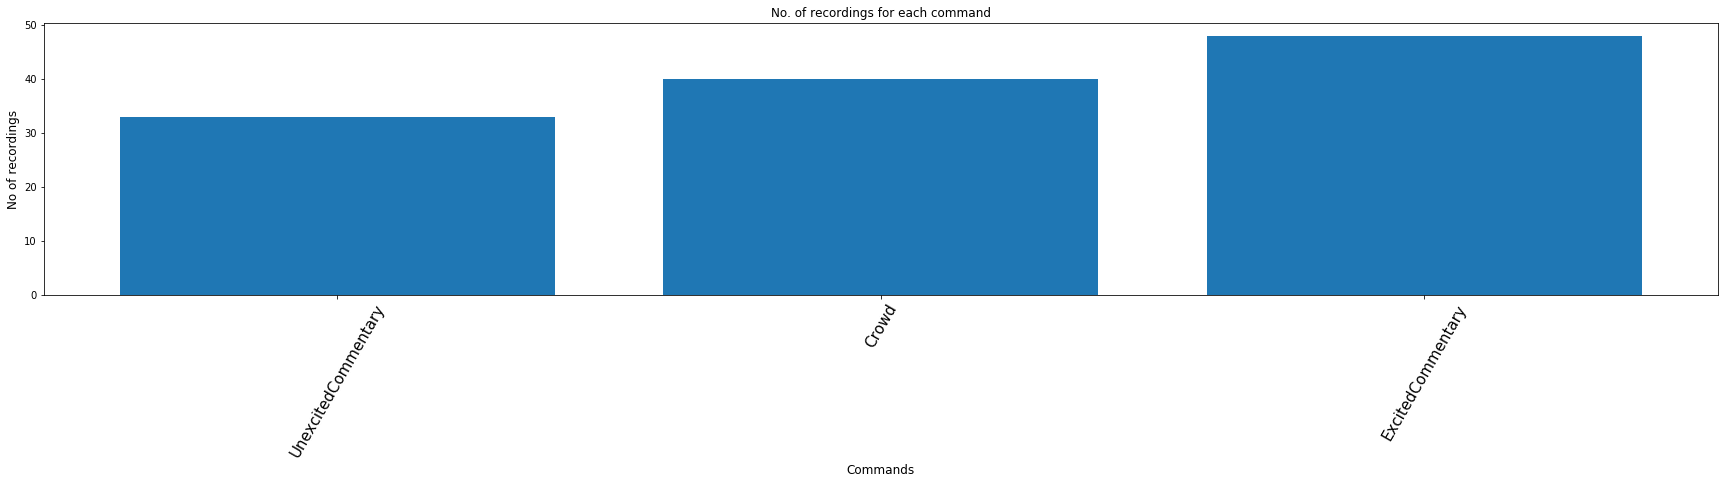

In [26]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

#labels=["Crowd", "ExcitedCommentary", "UnexcitedCommentary", "Whistle"]
labels=["Crowd", "ExcitedCommentary", "UnexcitedCommentary"]

(array([47.,  5., 19., 13.,  4.,  0.,  1.,  0.,  1.,  1.]),
 array([ 2.86147392,  6.81955329, 10.77763265, 14.73571202, 18.69379138,
        22.65187075, 26.60995011, 30.56802948, 34.52610884, 38.48418821,
        42.44226757]),
 <a list of 10 Patch objects>)

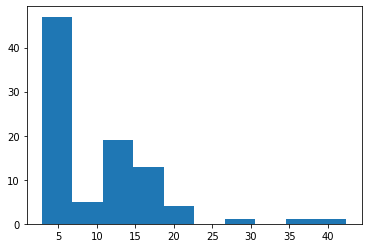

In [6]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [27]:
all_wave = []
all_label = []
sample_length = 110592
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 22050)
        samples = librosa.resample(samples, sample_rate, (sample_length*sample_rate)/len(samples))
        #print((8000*sample_rate)/len(samples), len(samples_8k))
        if(len(samples)== sample_length) : 
            all_wave.append(samples)
            all_label.append(label)

Crowd
ExcitedCommentary
UnexcitedCommentary


In [28]:
len(all_wave)

107

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [10]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

Using TensorFlow backend.


In [11]:
all_wave = np.array(all_wave).reshape(-1,sample_length,1)

In [12]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,shuffle=True)

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(sample_length,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fifth Conv1D layer
conv = Conv1D(128, 5, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Sixth Conv1D layer
conv = Conv1D(256, 3, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(512, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 3
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 110592, 1)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 110580, 8)         112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36860, 8)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36860, 8)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36850, 16)         1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12283, 16)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12283, 16)         0   

In [14]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=64, validation_data=(x_val,y_val))

Train on 65 samples, validate on 17 samples
Epoch 1/100
65/65 [==============================] - 4s 56ms/step - loss: 1.1029 - accuracy: 0.3077 - val_loss: 0.9534 - val_accuracy: 0.5294
Epoch 2/100
65/65 [==============================] - 3s 45ms/step - loss: 1.2456 - accuracy: 0.5538 - val_loss: 0.9442 - val_accuracy: 0.5294
Epoch 3/100
65/65 [==============================] - 3s 45ms/step - loss: 0.9001 - accuracy: 0.5231 - val_loss: 0.9611 - val_accuracy: 0.5294
Epoch 4/100
65/65 [==============================] - 3s 45ms/step - loss: 0.8347 - accuracy: 0.5538 - val_loss: 1.0051 - val_accuracy: 0.5294
Epoch 5/100
65/65 [==============================] - 3s 45ms/step - loss: 0.8021 - accuracy: 0.5538 - val_loss: 1.0612 - val_accuracy: 0.5294
Epoch 6/100
65/65 [==============================] - 3s 45ms/step - loss: 0.8367 - accuracy: 0.5538 - val_loss: 1.0708 - val_accuracy: 0.4118
Epoch 7/100
65/65 [==============================] - 3s 46ms/step - loss: 0.8614 - accuracy: 0.5846 - va

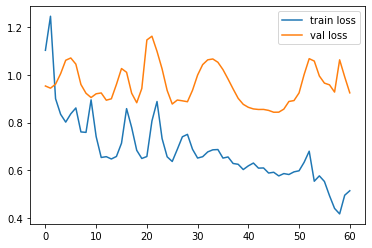

In [17]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train loss') 
pyplot.plot(history.history['val_loss'], label='val loss') 
pyplot.legend()
pyplot.show()

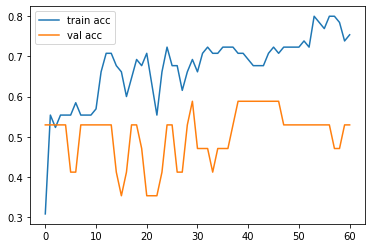

In [18]:
from matplotlib import pyplot 
pyplot.plot(history.history['accuracy'], label='train acc') 
pyplot.plot(history.history['val_accuracy'], label='val acc') 
pyplot.legend()
pyplot.show()

In [19]:
pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /opt/anaconda3/lib/python3.7/site-packages (0.23.2)
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix
y_pred = model.predict(x_val, batch_size=16)
print('Confusion Matrix')
print(labels)
print(confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

Confusion Matrix
['Crowd', 'ExcitedCommentary', 'UnexcitedCommentary']
[[0 0 2]
 [0 4 5]
 [0 1 5]]


In [21]:
def predict(audio):
    prob=model.predict(audio.reshape(1,sample_length,1))
    index=np.argmax(prob[0])
    return classes[index]

In [22]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: ExcitedCommentary
Text: UnexcitedCommentary


## Using MFCC features

## Utility

In [23]:
!pip install moviepy

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [29]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

# Segments audio into clips
start = 0
for index in range(565):
    ffmpeg_extract_subclip("tmp/audio.wav", start+index*5, start+(index+1)*5, targetname="tmp/segment" + str(start+index*5) + ".wav")


Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Movi